In [1]:
import pickle
import os

if not os.path.exists('secret_twitter_credentials.pkl'):
    Twitter={}
    Twitter['Consumer Key'] = ''
    Twitter['Consumer Secret'] = ''
    Twitter['Access Token'] = ''
    Twitter['Access Token Secret'] = ''
    with open('secret_twitter_credentials.pkl','wb') as f:
        pickle.dump(Twitter, f)
else:
    Twitter=pickle.load(open('secret_twitter_credentials.pkl','rb')) #The .pkl file is already created.   

In [2]:
import twitter

auth = twitter.oauth.OAuth(Twitter['Access Token'],
                           Twitter['Access Token Secret'],
                           Twitter['Consumer Key'],
                           Twitter['Consumer Secret'])

twitter_api = twitter.Twitter(auth=auth)
print(twitter_api)

In [3]:
WORLD_WOE_ID = 1
US_WOE_ID = 23424977

world_trends = twitter_api.trends.place(_id=WORLD_WOE_ID)
us_trends = twitter_api.trends.place(_id=US_WOE_ID)

In [4]:
import json

# print((json.dumps(world_trends[:10], indent=1)))
# print((json.dumps(us_trends[:10], indent=1)))

## Spiderman Into The Spiderverse

In [5]:
id_list = []
text_list = []
def searchTwitter(hashtag,max_id,count,lang):
    subject = twitter_api.search.tweets(q=hashtag,count=count,max_id=max_id,lang=lang,result_type='mixed')
    tweets = [dict(i) for i in subject['statuses']] 
    for i in range(len(tweets)):
        text_list.append(tweets[i]['text'])
        id_list.append(tweets[i]['id'])

hashtag = '#SpiderVerse'
count = 100
result_multiple = 15
searchTwitter(hashtag,False,count,'en')
for t in range(result_multiple):
    searchTwitter(hashtag,str(min(id_list)),count,'en')

  

In [6]:
len(id_list)

1600

In [7]:
import pandas as pd

SpiderDf = pd.DataFrame()
SpiderDf['ID'] = id_list
SpiderDf['Text'] = text_list
# SpiderDf.to_csv('Spiderman Tweets', sep=',', encoding='utf-8') #save data

In [8]:
SpiderDf.head(10)

,ID,Text
0,1082691162941648896,Putting on my Hamilton blouse today w big #Spi...
1,1082786350053707776,"#SpiderVerse rehearsal, #HamiltonPR https://t...."
2,1082466481433014272,"Meanwhile, in another, another universe... #Sp..."
3,1083115135542181889,RT @Spider_Ren: Miles Back At It Again at kris...
4,1083115131066769408,RT @SonyAnimation: Congratulations to the #Spi...
5,1083115129741418496,RT @TheCabbagethief: Everyone can stop posting...
6,1083115116969816064,RT @Bakestain: My SPIDER-VERSE Personal Projec...
7,1083115114541318145,RT @kadeart: BEST GIRL #SpiderVerse https://t....
8,1083115112796438530,"RT @Lin_Manuel: #SpiderVerse rehearsal, #Hamil..."
9,1083115099605200896,RT @SonyAnimation: Congratulations to the #Spi...


In [9]:
#Get the twitter_samples database with 5000 positive tweets and 5000 negative tweets
import nltk
# nltk.download("twitter_samples")
from nltk.corpus import twitter_samples
# print (twitter_samples.fileids())

In [10]:
#Clean and Tokenize tweets
import string
import re
 
from nltk.corpus import stopwords 
stopwords_english = stopwords.words('english')
 
from nltk.stem import PorterStemmer
stemmer = PorterStemmer() #This is used to reduce the words to their stem word ('likely' becomes 'like').

from nltk.tokenize import TweetTokenizer

#Use a variable for the positive, negative and all tweets using their respective file name:
pos_tweets = twitter_samples.strings('positive_tweets.json')
neg_tweets = twitter_samples.strings('negative_tweets.json')
all_tweets = twitter_samples.strings('tweets.20150430-223406.json')

#Choose elements to remove:
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)

def cleanAndTokenizeTweets(tweet):
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
 
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
 
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
 
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
 
    tweets_clean = []    
    for word in tweet_tokens:
        if (word not in stopwords_english and # remove stopwords
              word not in emoticons and # remove emoticons
                word not in string.punctuation): # remove punctuation
            #tweets_clean.append(word)
            stem_word = stemmer.stem(word) # stemming word
            tweets_clean.append(stem_word)
 
    return tweets_clean

In [11]:
#Create a bag of words function that cleans and tokenizes tweets, then returns the bag.
def bag_of_words(tweet):
    words = cleanAndTokenizeTweets(tweet)
    words_dictionary = dict([word, True] for word in words)    
    return words_dictionary

#Create a list of bags of words with all positive tweets
pos_tweets_set = []
for tweet in pos_tweets:
    pos_tweets_set.append((bag_of_words(tweet), 'pos')) 
    
#Create a list of bags of words with all negative tweets
neg_tweets_set = []
for tweet in neg_tweets:
    neg_tweets_set.append((bag_of_words(tweet), 'neg'))

print (len(pos_tweets_set), len(neg_tweets_set)) #Check the legths of each

5000 5000


In [12]:
# Radomize pos_reviews_set and neg_reviews_set
# doing so will output different accuracy result everytime we run the program
from random import shuffle 
shuffle(pos_tweets_set)
shuffle(neg_tweets_set)
 
test_set = pos_tweets_set[:1000] + neg_tweets_set[:1000]
train_set = pos_tweets_set[1000:] + neg_tweets_set[1000:]
 
print(len(test_set),  len(train_set)) # Check the number of tweets in test and train

2000 8000


In [13]:
#Training Classifier and Calculating Accuracy
from nltk import classify
from nltk import NaiveBayesClassifier
 
classifier = NaiveBayesClassifier.train(train_set)
 
accuracy = classify.accuracy(classifier, test_set)
print(accuracy)
print (classifier.show_most_informative_features(10))    

0.73
Most Informative Features
                     via = True              pos : neg    =     35.0 : 1.0
                     bam = True              pos : neg    =     26.3 : 1.0
                    sick = True              neg : pos    =     24.3 : 1.0
                     sad = True              neg : pos    =     21.2 : 1.0
                 appreci = True              pos : neg    =     20.3 : 1.0
                     x15 = True              neg : pos    =     19.0 : 1.0
                     ugh = True              neg : pos    =     15.0 : 1.0
                    glad = True              pos : neg    =     13.8 : 1.0
                 perfect = True              pos : neg    =     13.0 : 1.0
                  welcom = True              pos : neg    =     13.0 : 1.0
None


In [14]:
#Testing Classifier with Custom Tweet
#Custom negative tweet
custom_tweet_neg = "I hated the film. It was a disaster. Poor direction, bad acting."
custom_tweetNeg_set = bag_of_words(custom_tweet_neg)
print (classifier.classify(custom_tweetNeg_set))

custom_tweet_pos = "It was a wonderful and amazing movie. I loved it. Best direction, good acting."
custom_tweetPos_set = bag_of_words(custom_tweet_pos)
print (classifier.classify(custom_tweetPos_set))

neg
pos


### Precision, Recall & F1-Score
__Accuracy__ is (correctly predicted observation) / (total observation).

__Precision__ is about being precise.

– It shows how many correct predictions were given.

– For example, out of 100 questions, if you answered only 1 question and answered it correctly then you will have 100% precision.

– It’s about checking how often the classifier predicts the result correctly.

__Recall__ (as opposed to precision)

– is about answering all questions that have the answer “true” with the answer “true”.

– It’s about checking how often does the classifier predicts “yes” when the result is actually “yes”.

__F1 Score or F-measure:__ Harmonic mean of recall and precision.

In [15]:
from collections import defaultdict
from nltk.metrics import precision, recall, f_measure, ConfusionMatrix

actual_set = defaultdict(set)
predicted_set = defaultdict(set)
 
actual_set_cm = []
predicted_set_cm = []
 
for index, (feature, actual_label) in enumerate(test_set):
    actual_set[actual_label].add(index)
    actual_set_cm.append(actual_label)
 
    predicted_label = classifier.classify(feature)
 
    predicted_set[predicted_label].add(index)
    predicted_set_cm.append(predicted_label)

print('pos precision:', precision(actual_set['pos'], predicted_set['pos']))
print('pos recall:', recall(actual_set['pos'], predicted_set['pos'])) 
print('pos F-measure:', f_measure(actual_set['pos'], predicted_set['pos']))
print('neg precision:', precision(actual_set['neg'], predicted_set['neg']))
print('neg recall:', recall(actual_set['neg'], predicted_set['neg'])) 
print('neg F-measure:', f_measure(actual_set['neg'], predicted_set['neg'])) 

pos precision: 0.7380952380952381
pos recall: 0.713
pos F-measure: 0.7253306205493388
neg precision: 0.7224371373307543
neg recall: 0.747
neg F-measure: 0.7345132743362831


In [16]:
#The confusion matrix describes the performance of the classifier.
#When you see the matrix, the result in (negative row, negative column) is the number of correct negatives,
#same for (positive row, positive column). The result in (negative row, positive column) is number of
#incorrect negatives.
# Confusion Matrix for the test set
# 
# Output: 
# row = actual_set_cm 
# column = predicted_set_cm
cm = ConfusionMatrix(actual_set_cm, predicted_set_cm)
print (cm)
 
print (cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))


    |   n   p |
    |   e   o |
    |   g   s |
----+---------+
neg |<747>253 |
pos | 287<713>|
----+---------+
(row = reference; col = test)

    |      n      p |
    |      e      o |
    |      g      s |
----+---------------+
neg | <37.4%> 12.7% |
pos |  14.3% <35.6%>|
----+---------------+
(row = reference; col = test)



In [17]:
#Create bag of words for each of the SpiderVerse tweets
Spider_text_set = []
for text in SpiderDf['Text']:
    Spider_text_set.append(bag_of_words(text))

#Classify each bag of words
Spider_result = []
for bag in Spider_text_set:
    Spider_result.append(classifier.classify(bag))
    
    

In [18]:
SpiderDf['Sentiment'] = Spider_result

plotSeries = SpiderDf['Sentiment'].value_counts()

import pylab

pylab.bar(plotSeries.index,plotSeries.values)
pylab.show()

<Figure size 640x480 with 1 Axes>

## Aquaman

In [19]:
id_list = []
text_list = []
def searchTwitter(hashtag,max_id,count,lang):
    subject = twitter_api.search.tweets(q=hashtag,count=count,max_id=max_id,lang=lang,result_type='mixed')
    tweets = [dict(i) for i in subject['statuses']] 
    for i in range(len(tweets)):
        text_list.append(tweets[i]['text'])
        id_list.append(tweets[i]['id'])

hashtag = '#Aquaman'
count = 100
result_multiple = 15
searchTwitter(hashtag,False,count,'en')
for t in range(result_multiple):
    searchTwitter(hashtag,str(min(id_list)),count,'en')

len(id_list)

1600

In [23]:
AquamanDf = pd.DataFrame()
AquamanDf['ID'] = id_list
AquamanDf['Text'] = text_list
# AquamanDf.to_csv('Aquaman Tweets', sep=',', encoding='utf-8') #save data
AquamanDf.head(10)

,ID,Text
0,1082820760140423169,RT &amp; follow @OriginalFunko for a chance to...
1,1082608655160078336,Marvel President Kevin Feige really enjoyed #A...
2,1082609842873864194,Y’all really came on here to say #Aquaman was ...
3,1083115638053310475,My quick review of #Aquaman : I had a hell of ...
4,1083115634261676033,"Wow, #Aquaman was really enjoyable. Knock-off ..."
5,1083115586035609603,RT @Dommnics: Here's something I drew in celeb...
6,1083115583770636289,RT @OriginalFunko: RT &amp; follow @OriginalFu...
7,1083115572014006273,Up for grabs and minty #MEGO #Aquaman 1974 * E...
8,1083115567157047296,RT @DCFUnited: Postvis VFX iconic shot!!! #Aqu...
9,1083115549163511809,RT @AmberHeardIT: #AmberHeard and #CamilaCabel...


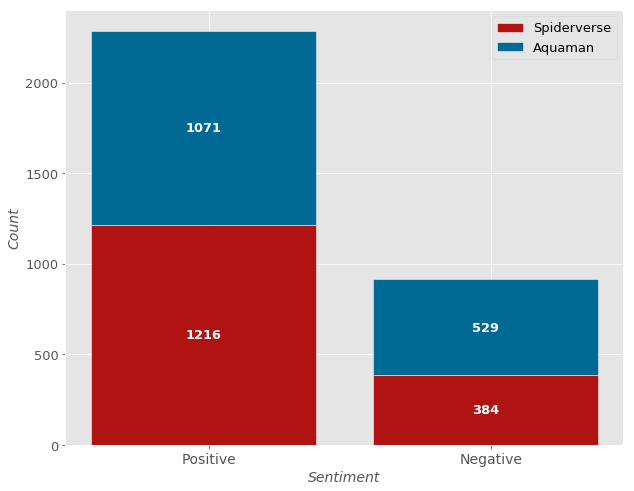

In [21]:
#Create bag of words for each of the SpiderVerse tweets
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

Aquaman_text_set = []
for text in AquamanDf['Text']:
    Aquaman_text_set.append(bag_of_words(text))

#Classify each bag of words
Aquaman_result = []
for bag in Aquaman_text_set:
    Aquaman_result.append(classifier.classify(bag))

AquamanDf['Sentiment'] = Aquaman_result

plotSeries1 = AquamanDf['Sentiment'].value_counts()


fig = plt.figure(facecolor="white",figsize=(10,8))
bar_width = 0.4
ax = fig.add_subplot(1, 1, 1)
r = [0,0.5] #Space between bars
tick_pos = [i + (bar_width/40) for i in r]

ax1 = ax.bar(r, plotSeries.values, width=bar_width, label='Spiderverse', color='#B11313',edgecolor='white' )
ax2 = ax.bar(r, plotSeries1.values, bottom=plotSeries.values, width=bar_width, label='Aquaman', 
             color='#006994',edgecolor='white')
ax.set_ylabel("Count", fontsize=14, style='italic')
ax.set_xlabel("Sentiment", fontsize=14, style='italic')
ax.legend(loc='best')
plt.xticks(tick_pos, ["Positive", "Negative"], fontsize=14)
plt.yticks(fontsize=13)

for r1, r2 in zip(ax1, ax2): #Code to configure text inside each plot
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center", 
             color="white", fontsize=13, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center", 
             color="white", fontsize=13, fontweight="bold")
plt.legend(prop={'size': 13})
plt.show()



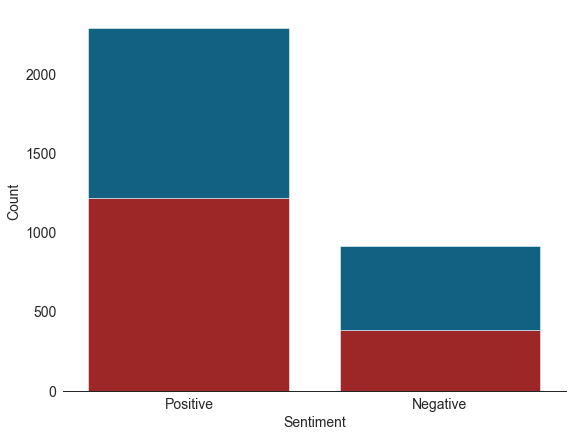

In [22]:
sns.set_style("white")
sns.set_context({"figure.figsize": (9, 7)})

r = ['Positive','Negative']
#Plot 1 - background - "total" (top) series
x1 = sns.barplot(r, plotSeries.values, color = "#B11313")

#Plot 2 - overlay - "bottom" series
x2 = sns.barplot(r, plotSeries1.values, color = "#006994",bottom=plotSeries.values)

# topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
# bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
# l = plt.legend([bottombar, topbar], ['Bottom Bar', 'Top Bar'], loc=1, ncol = 2, prop={'size':12})
# l.draw_frame(False)





#Optional code - Make plot look nicer
sns.despine(left=True)
x1.set_ylabel("Count")
x1.set_xlabel("Sentiment")

for item in ([x1.xaxis.label, x1.yaxis.label] +
             x1.get_xticklabels() + x1.get_yticklabels()):
    item.set_fontsize(14)